In [1]:
from BFCalc.createspectragrids import singlechannel_diffflux, getspectrafunc, darkmatterdoubleinput, energymassinputspectralfunc
from utils3d import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from astropy import units as u
from scipy import special,stats
from scipy.integrate import simps
from matplotlib import cm
from tqdm.autonotebook import tqdm as notebook_tqdm
import os, sys
import functools
from multiprocessing import Pool, freeze_support
import multiprocessing

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

/Users/lpin0002/anaconda3/envs/please/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# psfmatrix = np.load("psfmatrix.npy")

In [3]:
# psfinterpolation = interpolate.RegularGridInterpolator((log10eaxistrue, longitudeaxistrue, latitudeaxistrue, longitudeaxis, latitudeaxis),
                                                        #  np.exp(psfmatrix), method='nearest')

In [4]:
# %%timeit

# arrays = np.zeros(int(1e7))

# psf_efficient(arrays, arrays, arrays)

In [5]:
# print(5.78/60/60/24/7*log10eaxistrue.shape[0]*longitudeaxistrue.shape[0]*latitudeaxistrue.shape[0])
# print(0.0214/60/60/24/7*log10eaxistrue.shape[0]*longitudeaxistrue.shape[0]*latitudeaxistrue.shape[0])

In [6]:
%%time
psfnorm = []
for logeval in tqdm(log10eaxistrue):
    psflogerow = []
    for lonval in longitudeaxistrue:
        log10eaxistrue_mesh, longitudeaxistrue_mesh, latitudeaxistrue_mesh, longitudeaxis_mesh, latitudeaxis_mesh  = np.meshgrid(logeval,
                                                                                                                                lonval, 
                                                                                                                                latitudeaxistrue, 
                                                                                                                                longitudeaxis, 
                                                                                                                                latitudeaxis, indexing='ij')

        truecoords = np.array([longitudeaxistrue_mesh.flatten(), latitudeaxistrue_mesh.flatten()])

        recon_coords = np.array([longitudeaxis_mesh.flatten(), latitudeaxis_mesh.flatten()])

        rad = angularseparation(recon_coords, truecoords)
        offset = convertlonlat_to_offset(truecoords)

        psfvals = psf_efficient(rad, log10eaxistrue_mesh.flatten(), offset).reshape(log10eaxistrue_mesh.shape)
        
        psfnormvals = special.logsumexp(psfvals, axis=(-2,-1))
        
        psflogerow.append(psfnormvals)
    psfnorm.append(psflogerow)
            

  0%|          | 0/341 [00:00<?, ?it/s]

100%|██████████| 341/341 [01:56<00:00,  2.94it/s]

CPU times: user 1min 55s, sys: 834 ms, total: 1min 56s
Wall time: 1min 56s


In [7]:
psfnorm = np.squeeze(np.array(psfnorm))
psfnorm.shape

(341, 35, 30)

In [8]:
log10eaxistrue.shape, longitudeaxistrue.shape, latitudeaxistrue.shape, log10eaxis.shape, longitudeaxis.shape, latitudeaxis.shape

((341,), (35,), (30,), (171,), (18,), (15,))

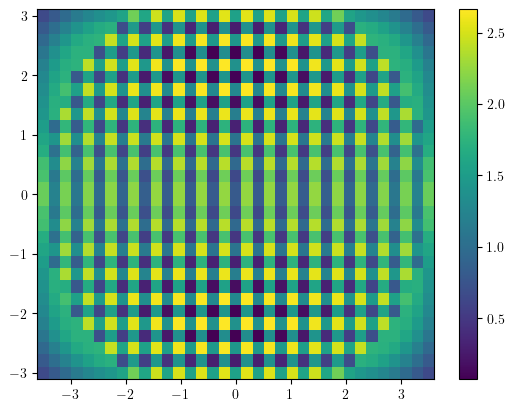

In [11]:
plt.figure()
plt.pcolormesh(longitudeaxistrue, latitudeaxistrue, psfnorm[0].T)
plt.colorbar()
plt.show()

In [10]:
psfnorm[0,35,30], log10eaxistrue[0], longitudeaxistrue[35], latitudeaxistrue[30]

IndexError: index 35 is out of bounds for axis 1 with size 35

In [12]:
log10eaxistrue_mesh, longitudeaxistrue_mesh, latitudeaxistrue_mesh, longitudeaxis_mesh, latitudeaxis_mesh  = np.meshgrid(log10eaxistrue[0],
                                                                                                                         longitudeaxistrue[35],
                                                                                                                         latitudeaxistrue[30],
                                                                                                                         longitudeaxis,
                                                                                                                         latitudeaxis, indexing='ij')

truecoords = np.array([longitudeaxistrue_mesh.flatten(), latitudeaxistrue_mesh.flatten()])

recon_coords = np.array([longitudeaxis_mesh.flatten(), latitudeaxis_mesh.flatten()])

rad = angularseparation(recon_coords, truecoords)
offset = convertlonlat_to_offset(truecoords)

psfvals = psf_efficient(rad, log10eaxistrue_mesh.flatten(), offset).reshape(log10eaxistrue_mesh.shape)

psfnormval = special.logsumexp(psfvals)

psfnormval, psfnorm[0,35,30]

IndexError: index 35 is out of bounds for axis 0 with size 35

In [13]:
%%time
edispnorm = []
for logeval in tqdm(log10eaxistrue):
    log10eaxistrue_mesh, longitudeaxistrue_mesh, latitudeaxistrue_mesh, log10eaxis_mesh  = np.meshgrid(logeval,
                                                                                                        longitudeaxistrue, 
                                                                                                        latitudeaxistrue, 
                                                                                                        log10eaxis,
                                                                                                        indexing='ij')

    truecoords = np.array([longitudeaxistrue_mesh.flatten(), latitudeaxistrue_mesh.flatten()])
    
    offset = convertlonlat_to_offset(truecoords)

    edispvals = np.squeeze(edisp_efficient(log10eaxis_mesh.flatten(), log10eaxistrue_mesh.flatten(), offset).reshape(log10eaxistrue_mesh.shape))
        
    edispnormvals = np.squeeze(special.logsumexp(edispvals+logjacob, axis=-1))
    
    edispnorm.append(edispnormvals)


edispnorm = np.array(edispnorm)

edispnorm.shape, psfnorm.shape

100%|██████████| 341/341 [00:15<00:00, 22.17it/s]

CPU times: user 15.2 s, sys: 192 ms, total: 15.4 s
Wall time: 15.4 s


((341, 35, 30), (341, 35, 30))

In [16]:
log10eaxistrue_mesh, longitudeaxistrue_mesh, latitudeaxistrue_mesh, log10eaxis_mesh  = np.meshgrid(log10eaxistrue[0],
                                                                                                        longitudeaxistrue[10], 
                                                                                                        latitudeaxistrue[10], 
                                                                                                        log10eaxis,
                                                                                                        indexing='ij')

truecoords = np.array([longitudeaxistrue_mesh.flatten(), latitudeaxistrue_mesh.flatten()])

offset = convertlonlat_to_offset(truecoords)

edispvals = np.squeeze(edisp_efficient(log10eaxis_mesh.flatten(), log10eaxistrue_mesh.flatten(), offset).reshape(log10eaxistrue_mesh.shape))

edispnormval = np.squeeze(special.logsumexp(edispvals+logjacob, axis=-1))



edispnormval, edispnorm[0,10,10]

(0.02548423087947671, 0.02548423087947671)

In [17]:
edispnorm[np.isneginf(edispnorm)] = 0
psfnorm[np.isneginf(psfnorm)] = 0


np.save("psfnormalisation.npy", psfnorm)
np.save("edispnormalisation.npy", edispnorm)

In [68]:
               # mins, secs, events, cores, complexityfactor, numberofsimulatenousjobs
newirfwaytime = (33,    9,   1e4,    2,     6,                30)
oldirfwaytime = (11,   13,   1e4,    2,     6,                20)

runvalues = oldirfwaytime

exampleeventtime_seconds = runvalues[1]
exampleeventtime_mins = runvalues[0]
examplenumevents = runvalues[2]
examplenumcores = runvalues[3]
complexityfactor_increase = runvalues[4]
numberofsimultaneousjobs = runvalues[5]


wantedevents = 1e7
min_to_hour_conversion = 60
num_cores = 32


numhours = ((exampleeventtime_mins+exampleeventtime_seconds/60)/min_to_hour_conversion) * (wantedevents/examplenumevents) * (examplenumcores/num_cores) / numberofsimultaneousjobs * complexityfactor_increase
print(f'{round(numhours,2)} hours')

3.51 hours


In [65]:
16*64

1024

In [60]:
%%time
log10eaxistrue = np.linspace(log10eaxistrue[0], log10eaxistrue[-1], 300)
longitudeaxistrue= np.linspace(longitudeaxistrue[0], longitudeaxistrue[-1], 300)
longitudeaxis = np.linspace(longitudeaxis[0], longitudeaxis[-1], 300)


longitudeaxistrue_mesh, log10eaxistrue_mesh, latitudeaxistrue_mesh, longitudeaxis_mesh, latitudeaxis_mesh  = np.meshgrid(longitudeaxistrue, 
                                                                                                                        log10eaxistrue, 
                                                                                                                        0.0, 
                                                                                                                        0.0, 
                                                                                                                        0.0)


psfoutput = psf_efficient(angularseparation(np.array([longitudeaxistrue_mesh.flatten(), latitudeaxistrue_mesh.flatten()]),
                                np.array([longitudeaxis_mesh.flatten(), latitudeaxis_mesh.flatten()])),
            log10eaxistrue_mesh.flatten(),
            convertlonlat_to_offset(np.array([longitudeaxistrue_mesh.flatten(), latitudeaxistrue_mesh.flatten()]))).reshape(longitudeaxistrue_mesh.shape)

    


CPU times: user 61.7 ms, sys: 12.9 ms, total: 74.6 ms
Wall time: 73.2 ms


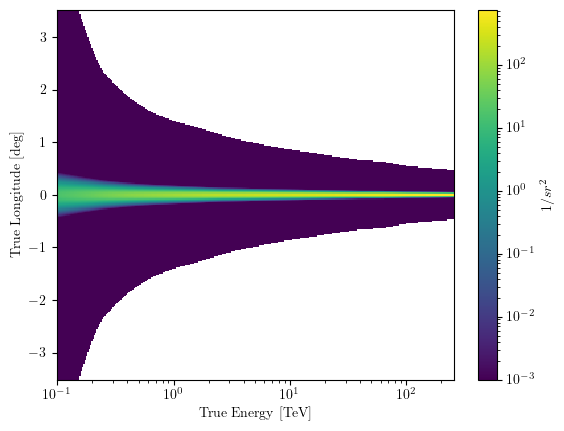

In [61]:
plt.figure()
plt.pcolormesh(10**log10eaxistrue, longitudeaxistrue, np.exp(np.squeeze(psfoutput).T), norm=LogNorm(vmin=1e-3))
plt.ylabel('True Longitude [deg]')
plt.xlabel('True Energy [TeV]')
plt.xscale('log')
plt.colorbar(label=r'$1/sr^2$')
plt.show()

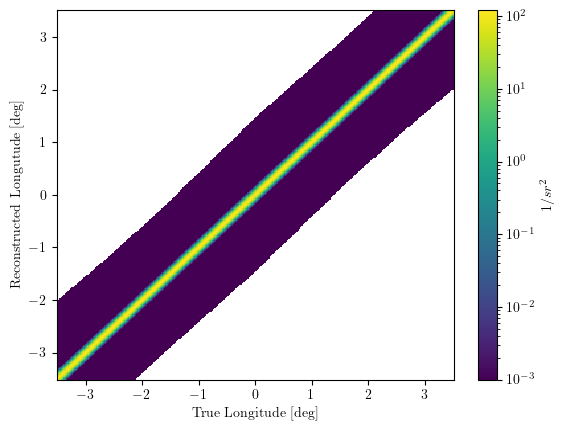

In [59]:
plt.figure()
plt.pcolormesh(longitudeaxistrue, longitudeaxis, np.exp(np.squeeze(psfoutput).T), norm=LogNorm(vmin=1e-3))
plt.xlabel('True Longitude [deg]')
plt.ylabel('Reconstructed Longutude [deg]')
plt.colorbar(label=r'$1/sr^2$')
plt.show()

In [ ]:
psfoutput.shape

(1, 60, 1, 30, 1)

In [ ]:
0.24*(1e7/100)/60/32/50

0.25

In [ ]:
32*50*1e4/1e7

1.6

In [ ]:
91//60

1

In [ ]:
timediffseconds = 3*60*60+4*60 + 3

In [ ]:
hours = timediffseconds//(60*60)

minutes = (timediffseconds-(60*60)*hours)//60
seconds = timediffseconds-(60*60)*hours-60*minutes

hours, minutes, seconds

(3, 4, 3)

In [69]:
# bfmlambdaarray = np.load("bfmlambdaarray.npy")

In [72]:

bfmlambdaarray = np.load("bfmlambdaarray.npy")
lambdarange = np.load("lambdarange.npy")
massrange = np.load("massrange.npy")


dataArr=bfmlambdaarray
  
Lambda = dataArr[0,:,1]
log_m_DM = np.log10(dataArr[:,0,0]/1e3)
relic = dataArr[:,:,2]
Bfw = dataArr[:,:,3]
Bfz = dataArr[:,:,4]
Bfh = dataArr[:,:,5]
Bfb = dataArr[:,:,6]
Bfc = dataArr[:,:,7]
Bfl = dataArr[:,:,8]
Bfg = dataArr[:,:,9]
Bft = dataArr[:,:,10]

In [82]:
log_m_DM.shape

(256,)

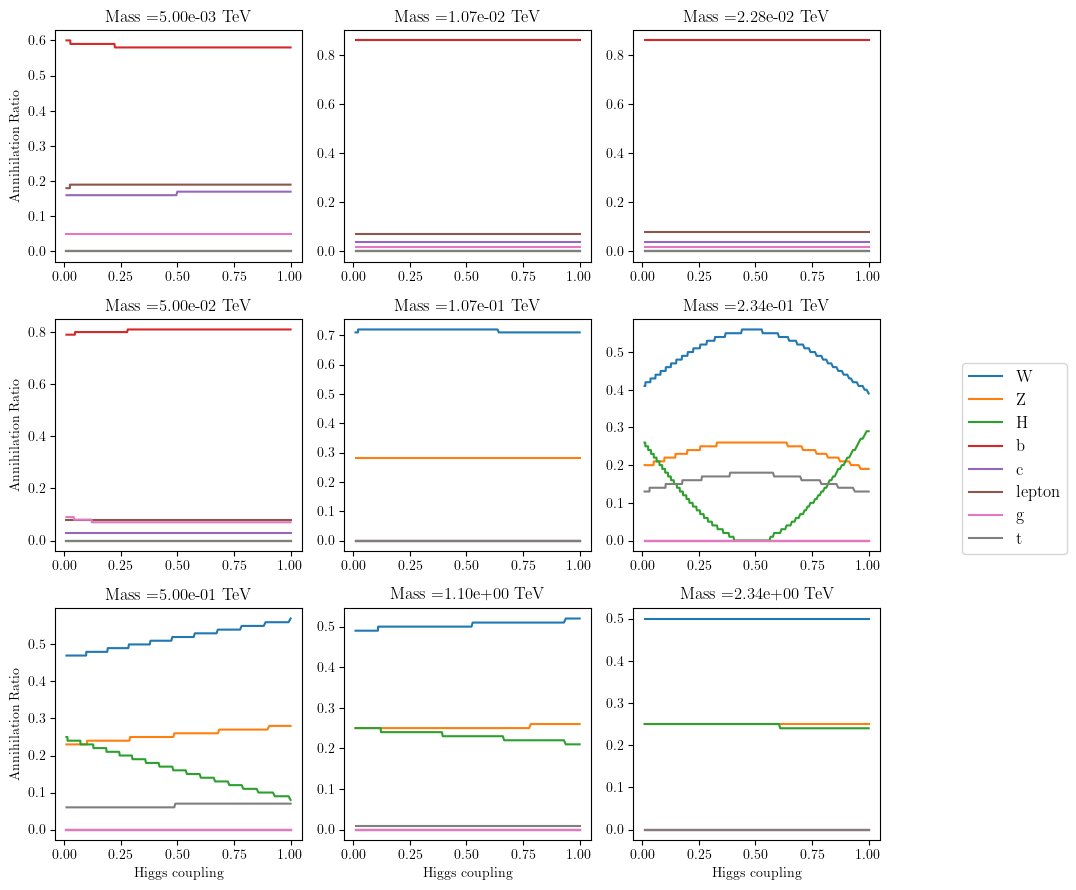

In [161]:
masslice = 120
length_logDM = len(list(log_m_DM))
numcols = 3
numrows = 3
numplots = numcols*numrows
colmesh, rowmesh = np.meshgrid(range(numrows), range(numcols), indexing='ij')

scaling_questionmark = False



fig, ax = plt.subplots(numrows, numcols, figsize=(3*numcols, 3*numrows))
for idx, axesidx  in enumerate(zip(rowmesh.flatten(), colmesh.flatten())):
    colidx, rowidx = axesidx
    ax[rowidx, colidx].set_title(f'Mass ={10**log_m_DM[int(idx/numplots*length_logDM)]:.2e} TeV')
    ax[rowidx, colidx].plot( Lambda, Bfw.T[:,int(idx/numplots*length_logDM)], label='W')
    ax[rowidx, colidx].plot( Lambda, Bfz.T[:,int(idx/numplots*length_logDM)], label='Z')
    ax[rowidx, colidx].plot( Lambda, Bfh.T[:,int(idx/numplots*length_logDM)], label='H')
    ax[rowidx, colidx].plot( Lambda, Bfb.T[:,int(idx/numplots*length_logDM)], label='b')
    ax[rowidx, colidx].plot( Lambda, Bfc.T[:,int(idx/numplots*length_logDM)], label='c')
    ax[rowidx, colidx].plot( Lambda, Bfl.T[:,int(idx/numplots*length_logDM)], label='lepton')
    ax[rowidx, colidx].plot( Lambda, Bfg.T[:,int(idx/numplots*length_logDM)], label='g')
    ax[rowidx, colidx].plot( Lambda, Bft.T[:,int(idx/numplots*length_logDM)], label='t')
    if scaling_questionmark:
        ax[rowidx, colidx].set_xlim([1e-2,None])
        ax[rowidx, colidx].set_xscale('log')
    if rowidx==numrows-1:
            ax[rowidx, colidx].set_xlabel('Higgs coupling')
    if colidx==0:
        ax[rowidx, colidx].set_ylabel('Annihilation Ratio')

handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.20, 0.6), fontsize=12*int(numrows/2))  # This is a common location for a legend

# Step 4: Position the legend outside the grid of plots
plt.subplots_adjust(right=0.85)


plt.tight_layout()

plt.show()

4.999999999999999


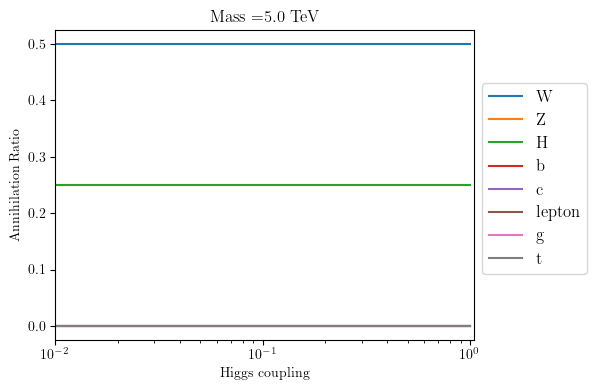

In [190]:
masslice = 120
logmassidx = np.where(log_m_DM==log_m_DM[np.abs(log_m_DM-np.log10(5)).argmin()])[0][0]
print(10**log_m_DM[logmassidx])

fig = plt.figure(figsize=(5,4))
plt.title(f'Mass ={10**log_m_DM[logmassidx]:.1f} TeV')
plt.plot( Lambda, Bfw.T[:,logmassidx], label='W')
plt.plot( Lambda, Bfz.T[:,logmassidx], label='Z')
plt.plot( Lambda, Bfh.T[:,logmassidx], label='H')
plt.plot( Lambda, Bfb.T[:,logmassidx], label='b')
plt.plot( Lambda, Bfc.T[:,logmassidx], label='c')
plt.plot( Lambda, Bfl.T[:,logmassidx], label='lepton')
plt.plot( Lambda, Bfg.T[:,logmassidx], label='g')
plt.plot( Lambda, Bft.T[:,logmassidx], label='t')
plt.xlim([1e-2,None])
plt.xscale('log')
plt.xlabel('Higgs coupling')
plt.ylabel('Annihilation Ratio')

fig.legend(handles, labels, bbox_to_anchor=(1.20, 0.8), fontsize=12)  # This is a common location for a legend


plt.tight_layout()

plt.show()